In [1]:
import os

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env

### Load Env and Get info

In [3]:
# Construct the environment
env = gym.make("tolman-10x10-latent")
env.reset()

({'agent': array([7, 0]), 'target': array([1, 9])}, {'distance': 15.0})

In [4]:
actions = np.arange(env.action_space.n, dtype=int)
start_loc = env.unwrapped.start_loc
target_loc = env.unwrapped.target_loc
maze = env.unwrapped.maze
size = maze.size
height, width = maze.shape
target_locs = [target_loc]

In [5]:
print(f"actions: {actions}, start loc: {start_loc}, target loc: {target_loc}, size: {size}, height: {height}, width: {width}")


actions: [0 1 2 3], start loc: [7 0], target loc: [1 9], size: 100, height: 10, width: 10


### Helper Functions

In [6]:
def get_blocked_states(maze):
    blocked_states = []

    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i,j] == "1":
                blocked_states.append((i,j))
    
    return blocked_states

In [7]:
def create_transition_matrix_mapping(maze):
    """
    Creates a mapping from maze state indices to transition matrix indices
    Returns for both the full maze (mapping_b), and the maze with no borders (mapping_nb)
    """
    blocked_states = get_blocked_states(maze)
    n = len(maze)  # Size of the maze (N)

    mapping_nb, mapping_b = {}, {}
    matrix_idx_nb, matrix_idx_b = 0, 0

    for i in range(n):
        for j in range(n):
            # If we higt a blocked state
            if (i, j) not in blocked_states:
                mapping_nb[(i, j)] = matrix_idx_nb
                matrix_idx_nb += 1
            mapping_b[(i,j)] = matrix_idx_b
            matrix_idx_b += 1

    return mapping_nb, mapping_b

In [8]:
mapping_nb, mapping_b = create_transition_matrix_mapping(maze)
reverse_mapping_nb = {index: (i, j) for (i, j), index in mapping_nb.items()}
reverse_mapping_b = {index: (i, j) for (i, j), index in mapping_b.items()}

In [9]:
def get_transition_matrix(size, mapping):
    T = np.zeros(shape=(size, size))
    # loop through the maze
    for row in range(maze.shape[0]):
        for col in range(maze.shape[1]):            
            # if we hit a barrier
            if maze[row,col] == '1':
                continue

            idx_cur = mapping[row, col]

            # check if current state is terminal
            if maze[row,col] == 'G':
                T[idx_cur, idx_cur] = 1
                continue

            state = (row,col)
            successor_states = env.unwrapped.get_successor_states(state)
            for successor_state in successor_states:
                idx_new = mapping[successor_state[0][0], successor_state[0][1]]
                T[idx_cur, idx_new] = 1
    
    return T

In [10]:
def one_hot_row(s_idx, size):
    row = np.zeros(size) 
    row[s_idx] = 1

    return row

In [11]:
T = get_transition_matrix(size=size, mapping=mapping_b)

In [12]:
# Get terminal states
terminals = np.diag(T) == 1

# Calculate P = T_{NT}
P = T[~terminals][:,terminals]

# Calculate reward
r = np.full(len(T), -1)     # our reward at each non-terminal state to be -1
r[terminals] = 10           # reward at terminal state is 10
c = -r

### LRL-TD

In [13]:
# Create a matrices needed for calculation
# DR = np.zeros((size,size))
# DR = np.eye(size-sum(terminals))
DR = np.eye(size)
Z = np.zeros(size)
V = np.zeros(size)
# one_hot = np.eye(size-sum(terminals))
one_hot = np.eye(size)

# Hyperparameters
alpha = 0.1
gamma = 0.8
epsilon = 0.2

# Other things
num_steps = 50000

In [14]:
# Z[terminals] = np.exp(r[terminals] / gamma)

In [15]:
# Calculate expr
expr = np.exp(r[terminals] / gamma)

In [16]:
def importance_sampling(state, s_new_idx):
    successor_states = env.unwrapped.get_successor_states(state)
    p = 1/len(successor_states)
    w = (p * Z[s_new_idx]) / sum(p * Z[mapping_b[(s[0][0],s[0][1])]] for s in successor_states)
    
    return w

In [17]:
env.reset()

# Iterate through number of steps
for i in range(num_steps):
    # Current state
    state = env.unwrapped.agent_loc
    state_idx = mapping_b[(state[0], state[1])]

    # Choose action (random for now)
    action = env.unwrapped.random_action()

    # Take action
    obs, _, done, _, _ = env.step(action)

    if done:
        env.reset()
        continue

    # Unpack observation to get new state
    next_state = obs["agent"]
    next_state_idx = mapping_b[(next_state[0], next_state[1])]

    # Update Default Representation
    # w = importance_sampling(state, next_state_idx)
    # w = 1 if np.isnan(w) or w == 0 else w
    w = 1
    # DR[state_idx] = (1 - alpha) * DR[state_idx] + alpha * ( one_hot[state_idx] + gamma * DR[next_state_idx] ) * w
    DR[state_idx][~terminals] = (1 - alpha) * DR[state_idx][~terminals] + alpha * ( one_hot[state_idx][~terminals] + gamma * DR[next_state_idx][~terminals] ) * w

    # Update Z-Values
    # Z[state_idx] = DR[state_idx] @ P @ expr
    Z[state_idx] = DR[state_idx][~terminals] @ P @ expr

    # Update state
    state = next_state

In [18]:
Z[terminals] = np.exp(r[terminals] / gamma)

In [19]:
v_maze = np.zeros_like(maze)
for row in range(v_maze.shape[0]):
    for col in range(v_maze.shape[1]):
        if maze[row, col] == "1":
            v_maze[row,col] = "BAR"
            continue
        v_maze[row,col] = round(np.log(Z[mapping_b[(row,col)]]), 2)

In [20]:
v_maze

array([['BAR', '0.77', 'BAR', 'BAR', '3.18', 'BAR', 'BAR', '12.04',
        '12.38', '12.85'],
       ['0.7', '1.36', '2.36', '3.2', '3.85', '3.5', 'BAR', '12.26',
        '13.0', '12.5'],
       ['0.72', '1.39', '2.54', '3.73', '4.91', '4.07', 'BAR', '11.74',
        'BAR', 'BAR'],
       ['BAR', '0.54', 'BAR', 'BAR', '6.11', 'BAR', 'BAR', '11.04',
        'BAR', 'BAR'],
       ['BAR', '-0.69', 'BAR', 'BAR', '6.5', '7.67', '8.6', '9.05',
        'BAR', 'BAR'],
       ['BAR', '-1.28', 'BAR', '5.58', '6.36', '7.39', '7.91', '7.97',
        'BAR', 'BAR'],
       ['BAR', '-2.22', 'BAR', '5.11', '5.58', 'BAR', 'BAR', '7.29',
        'BAR', 'BAR'],
       ['-4.21', '-3.29', 'BAR', '4.58', '4.58', 'BAR', '5.58', '6.22',
        'BAR', 'BAR'],
       ['-4.36', '-4.16', 'BAR', 'BAR', '3.94', 'BAR', '5.05', '4.96',
        '4.02', '3.6'],
       ['BAR', '-4.39', 'BAR', 'BAR', '3.63', 'BAR', 'BAR', '4.16',
        '3.74', '3.44']], dtype='<U21')

### Plotting

In [21]:
target_loc

array([1, 9])

In [22]:
def get_map():
    # Replace 'S' and 'G' with 0
    m = np.where(np.isin(maze, ['S', 'G']), '0', maze)

    # Convert the array to int
    m = m.astype(int)
    
    return m

def render_maze(state, ax=None):    
    if ax is None:
        fig, ax = plt.subplots()
    m = get_map()
    
    # Display maze
    ax.imshow(m, origin='upper')
    # Display agent
    agent = patches.Circle((state[1],state[0]), radius=0.4, fill=True, color='white')
    ax.add_patch(agent)
    # Display Reward
    reward = patches.Circle((target_loc[1],target_loc[0]), radius=0.4, fill=True, color='green')
    ax.add_patch(reward)

    ax.set_title('Map')
    ax.set_axis_off()

def render_DR(DR, state, ax=None):
    state_idx = mapping_b[(state[0], state[1])]
    ax.imshow(DR[state_idx].reshape(height, width), 
              origin='upper', cmap='plasma')
    ax.set_title("DR(%d, %d)" % (state[0], state[1]))
    ax.set_axis_off()

def render_V(ax, values, vmax=None):
    min_value = np.min(values[~np.isinf(values)])
    max_value = np.max(values)

    cmap = plt.cm.Greys_r
    cmap.set_bad('black', 1.0)

    ax.imshow(values.reshape(height, width),
                origin='upper',
                cmap=cmap, vmin=min_value, vmax=max_value)
    ax.set_title("$Values$")
    ax.set_axis_off()

In [23]:
V = np.round(np.log(Z), 2)

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_68379/37569279.py:1: RuntimeWarning: divide by zero encountered in log
  V = np.round(np.log(Z), 2)


In [24]:
def make_plots(DR, state=None):
    # Adjust DR at terminal state
    idx = mapping_b[target_loc[0], target_loc[1]]
    DR[idx, :] = 0
    DR[idx, idx] = 1

    if state is None:
        state = start_loc
        # state = (0,0)
        
    fig, axs = plt.subplots(1, 3, dpi=144)
    render_maze(state, ax=axs[0])
    render_DR(DR, state, ax=axs[1])
    render_V(values=V, ax=axs[2])
    
    plt.show()

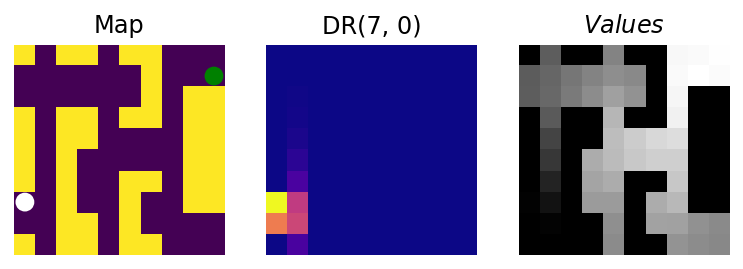

In [25]:
make_plots(DR=DR)

In [26]:
action_to_direction = {
    0: np.array([1, 0]),
    1: np.array([0, 1]),
    2: np.array([-1, 0]),
    3: np.array([0, -1]),
}

In [27]:
num_rows, num_cols = maze.shape

In [28]:
def select_action(state, policy="e-greedy", epsilon=0.0, target_loc=None):
    if policy == "softmax":
        return
    elif policy == "e-greedy":
        if np.random.uniform(low=0,high=1) < epsilon:
            return env.unwrapped.random_action()
        
        else:
            action_values = np.full(len(actions), -np.inf)
            for action in env.unwrapped.get_available_actions(state):
                direction = action_to_direction[action]
                new_state = state + direction
                if maze[new_state[0], new_state[1]] == "1":
                    continue
                action_values[action] = round(np.log(Z[mapping_b[(new_state[0],new_state[1])]]), 2)

            return np.argmax(action_values)
        
    elif policy == "test":
        action_values = np.full(len(actions), -np.inf)
        for action in env.unwrapped.get_available_actions(state):
            direction = action_to_direction[action]
            new_state = state + direction

            # Need this to make it work for now
            if np.array_equal(new_state, target_loc):
                return action

            if maze[new_state[0], new_state[1]] == "1":
                continue
            action_values[action] = round(np.log(Z[mapping_b[(new_state[0],new_state[1])]]), 2)

        return np.argmax(action_values)

In [29]:
maze

array([['1', '0', '1', '1', '0', '1', '1', '0', '0', '0'],
       ['0', '0', '0', '0', '0', '0', '1', '0', '0', 'G'],
       ['0', '0', '0', '0', '0', '0', '1', '0', '1', '1'],
       ['1', '0', '1', '1', '0', '1', '1', '0', '1', '1'],
       ['1', '0', '1', '1', '0', '0', '0', '0', '1', '1'],
       ['1', '0', '1', '0', '0', '0', '0', '0', '1', '1'],
       ['1', '0', '1', '0', '0', '1', '1', '0', '1', '1'],
       ['S', '0', '1', '0', '0', '1', '0', '0', '1', '1'],
       ['0', '0', '1', '1', '0', '1', '0', '0', '0', '0'],
       ['1', '0', '1', '1', '0', '1', '1', '0', '0', '0']], dtype='<U21')

In [30]:
env.reset()
state = start_loc
# set the start and agent location
env.unwrapped.start_loc, env.unwrapped.agent_loc = state, state
# print(state)
print(state)
steps = 0
done = False
while not done:
    action = select_action(state, policy="test", target_loc=env.unwrapped.target_loc)
    obs, _, done, _, _ = env.step(action)
    next_state = obs["agent"]
    print(f"Took action: {action} and arrived in state: {next_state}")

    steps += 1
    state = next_state
print(steps)

[7 0]
Took action: 1 and arrived in state: [7 1]
Took action: 2 and arrived in state: [6 1]
Took action: 2 and arrived in state: [5 1]
Took action: 2 and arrived in state: [4 1]
Took action: 2 and arrived in state: [3 1]
Took action: 2 and arrived in state: [2 1]
Took action: 1 and arrived in state: [2 2]
Took action: 1 and arrived in state: [2 3]
Took action: 1 and arrived in state: [2 4]
Took action: 0 and arrived in state: [3 4]
Took action: 0 and arrived in state: [4 4]
Took action: 1 and arrived in state: [4 5]
Took action: 1 and arrived in state: [4 6]
Took action: 1 and arrived in state: [4 7]
Took action: 2 and arrived in state: [3 7]
Took action: 2 and arrived in state: [2 7]
Took action: 2 and arrived in state: [1 7]
Took action: 1 and arrived in state: [1 8]
Took action: 1 and arrived in state: [1 9]
19


In [66]:
def record_trials(title="recorded_trials", n_trial_per_loc=1,
                    start_locs=None, max_steps=100):
    metadata = dict(title=title, artist='JG')
    writer = manimation.FFMpegFileWriter(fps=7, metadata=metadata)
    fig, axs = plt.subplots(1, 3, figsize=(7, 3))
    fig.tight_layout()

    with writer.saving(fig, "./out/%s.mp4" % title, 144):
        for sl in start_locs:
            for trial in range(n_trial_per_loc):
                env.reset()
                done = False
                steps = 0
                state = sl
                
                # set the start and agent location
                env.unwrapped.start_loc, env.unwrapped.agent_loc = state, state

                # Render starting state
                render_maze(state, ax=axs[0])
                render_DR(DR, state, ax=axs[1])
                render_V(values=V, ax=axs[2])
                writer.grab_frame()
                
                for ax in axs:
                        ax.clear()

                # Act greedily and record each state as well
                while not done and steps < max_steps:
                    action = select_action(state)
                    obs, _, done, _, _ = env.step(action)

                    render_maze(state, ax=axs[0])
                    render_DR(DR, state, ax=axs[1])
                    render_V(values=V, ax=axs[2])
                    writer.grab_frame()

                    steps += 1

                    state = obs["agent"]

                    for ax in axs:
                        ax.clear()

In [67]:
start_loc

array([7, 0])

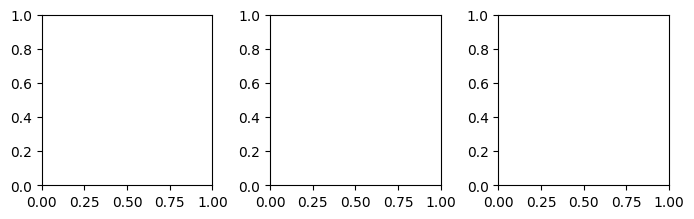

In [68]:
record_trials(title="tolman-latent-new-goal", 
                start_locs=np.array([[7,0], [1,0], [9,4], [0,4]]))
